<a href="https://colab.research.google.com/github/collisionattack/istanbul-traffic-forecasting/blob/main/notebooks/notebooks_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Reading the Data

In [1]:
import requests
import pandas as pd

def fetch_traffic_data(resource_id: str):
    """
    Fetches all traffic data as a single pandas.DataFrame.

    :param resource_id: CKAN resource UUID for the Istanbul traffic index.
    """
    BASE_URL = "https://data.ibb.gov.tr/api/3/action/datastore_search"
    params = {
        "resource_id": resource_id,
        "limit": 3332 # the total number of records
    }
    resp = requests.get(BASE_URL, params=params)
    resp.raise_for_status()
    records = resp.json()["result"]["records"]

    df = pd.DataFrame(records)
    df["trafficindexdate"] = pd.to_datetime(df["trafficindexdate"])

    return df

In [2]:
RESOURCE_ID = "ba47eacb-a4e1-441c-ae51-0e622d4a18e2"
df = fetch_traffic_data(RESOURCE_ID)

print(df.head())

   _id    trafficindexdate  minimum_traffic_index  maximum_traffic_index  \
0    1 2015-08-06 03:00:00                     24                     63   
1    2 2015-08-07 03:00:00                      2                     49   
2    3 2015-08-11 03:00:00                     11                     62   
3    4 2015-08-12 03:00:00                      1                     63   
4    5 2015-08-13 03:00:00                      2                     56   

   average_traffic_index  
0              57.858116  
1              23.770492  
2              38.601266  
3              29.715278  
4              28.557491  


## 2. EDA Section

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   _id                    3332 non-null   int64         
 1   trafficindexdate       3332 non-null   datetime64[ns]
 2   minimum_traffic_index  3332 non-null   int64         
 3   maximum_traffic_index  3332 non-null   int64         
 4   average_traffic_index  3332 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 130.3 KB


In [4]:
df.describe()

,_id,trafficindexdate,minimum_traffic_index,maximum_traffic_index,average_traffic_index
count,3332.000000,3332,3332.000000,3332.000000,3332.000000
mean,1666.500000,2020-03-24 13:49:44.153661184,2.075630,59.956483,27.830846
min,1.000000,2015-08-06 03:00:00,1.000000,4.000000,1.083916
25%,833.750000,2017-12-14 21:00:00,1.000000,53.000000,23.651568
50%,1666.500000,2020-03-27 15:00:00,1.000000,63.000000,28.979524
75%,2499.250000,2022-07-08 09:00:00,2.000000,71.000000,33.491313
max,3332.000000,2024-10-18 03:00:00,58.000000,90.000000,59.428571
std,962.009875,NaN,2.751651,15.613316,8.252579


In [5]:
# Checking the total of NaN values
df.isna().sum()

,0
_id,0
trafficindexdate,0
minimum_traffic_index,0
maximum_traffic_index,0
average_traffic_index,0


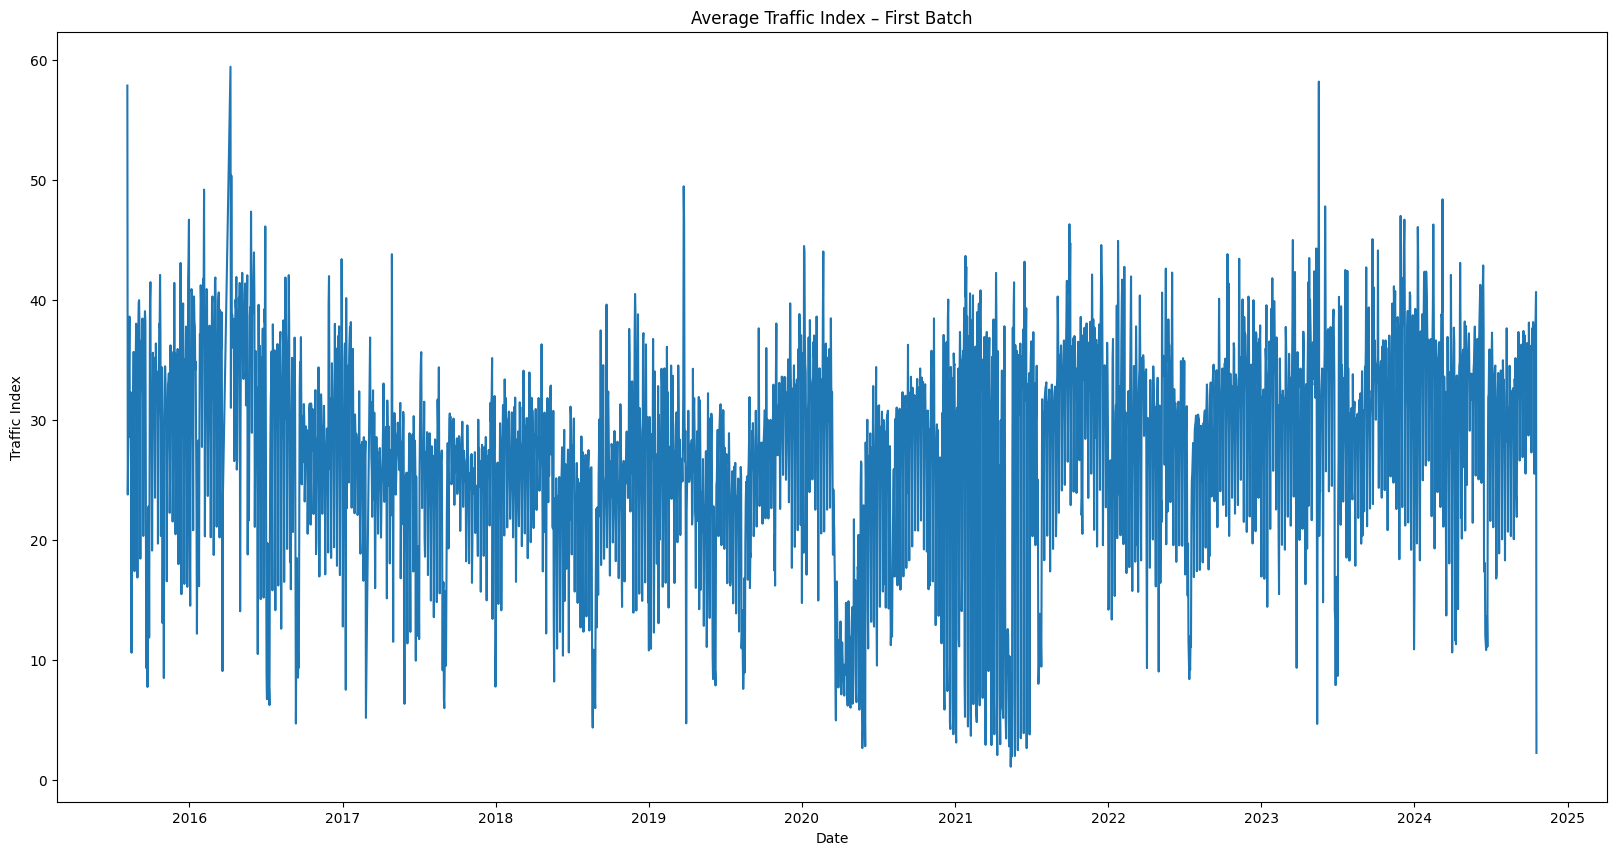

In [6]:
# First visual inspection
import matplotlib.pyplot as plt

df_sorted = df.sort_values("trafficindexdate")
plt.figure(figsize=(20, 10))
plt.plot(df_sorted["trafficindexdate"], df_sorted["average_traffic_index"])
plt.title("Average Traffic Index – First Batch")
plt.xlabel("Date")
plt.ylabel("Traffic Index")
plt.show()

### 2a. Preprocessing and Feature Engineering

In [7]:
# Filling the gaps for consistency
df = df.set_index("trafficindexdate").asfreq("D")

In [8]:
# Imputing missing values for some of the time gaps
df["minimum_traffic_index"] = df["minimum_traffic_index"].ffill().bfill()
df["maximum_traffic_index"] = df["maximum_traffic_index"].ffill().bfill()
df["average_traffic_index"] = df["average_traffic_index"].interpolate()

In [9]:
# Feature engineering part-1
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

In [10]:
# Feature engineering part-2 -> Lags for temporal learning
for lag in [1, 2, 7]:
    df[f"lag_{lag}"] = df["average_traffic_index"].shift(lag)

In [11]:
# Feature engineering part-3 -> Rolling average (trend)
df["rolling_mean_7"] = df["average_traffic_index"].rolling(7).mean()

In [12]:
# Feature engineering part-4 -> Drop rows with NaNs from lags/rolling
df = df.dropna()

## 2b. Data Split

In [14]:
# Defined features and target here. Traditionally X for features and y for target
y = "average_traffic_index"
X = [c for c in df.columns if c != y]

In [15]:
# Reserved the final 15% for test
n = len(df)
test_start = int(n * 0.85)
df_trainval = df.iloc[:test_start]
df_test = df.iloc[test_start:]

In [16]:
print(f"Total of train and val: {len(df_trainval)} rows,  Test : {len(df_test)} rows")

Total of train and val: 2714 rows,  Test : 480 rows


## 3. Initial Model Studies

### 3a. `RandomForestRegressor`

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns

In [20]:
# Defined features (X) and target (y) for train and test sets
X_train = df_trainval[X]
y_train = df_trainval[y]
X_test = df_test[X]
y_test = df_test[y]

In [21]:
# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

In [23]:
print(rf_predictions)

[10.18369119 12.96235632 14.68067033 14.99212642 12.00374794 10.64163006
 21.81207746 25.64955714 32.82282715 33.37807189 30.81188639 30.07995827
 23.82692612 28.04843078 35.92179103 35.30214831 35.97955242 33.56950622
 19.71711918 17.96033082 32.49281133 31.82383922 31.77472674 34.98821729
 28.65772122 23.6925442  19.36488195 28.93306448 33.52861034 27.09950046
 32.09419037 33.92474814 27.97296471 19.02451328 28.13205255 31.0065571
 30.63615801 30.81018738 28.29332675 26.29097864 15.72580272 30.29618468
 33.25009773 32.44540196 28.58451603 28.67552365 28.14193024 18.88025941
 29.43213889 27.83470408 30.10413906 30.0918795  30.43022509 23.83730608
 19.72159954 30.42372757 32.15741095 30.95363693 30.7637672  31.06649914
 24.25228325 22.79526982 28.34543976 33.88927902 24.92203433 29.41446727
 29.99656141 25.94305024 24.48818901 30.40264047 33.01272554 35.10626064
 34.69915247 36.10363029 28.29970095 22.92960059 29.18958115 32.57768489
 33.61027811 32.89980116 34.96474404 28.81719127 20.

In [24]:
# MAE
mae = mean_absolute_error(y_test, rf_predictions)
print(f"Random Forest MAE: {mae}")

Random Forest MAE: 2.5008008536587067


In [32]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rmse}")

Random Forest RMSE: 3.400938914489313


In [33]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAPE isn't robust for only for non-zero values, so we add a little conditional here
mape = mean_absolute_percentage_error(y_test[y_test != 0], rf_predictions[y_test != 0])
print(f"Random Forest MAPE: {mape}%")

Random Forest MAPE: 8.943302507885255%


In [34]:
# R-squared
r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest R²: {r2}")

Random Forest R²: 0.7735601390804803


In [26]:
# The two consecutive cells are for the visualization for comparison of between the predictions and the actual values
plot_df = df_test.copy()
plot_df['rf_predictions'] = rf_predictions

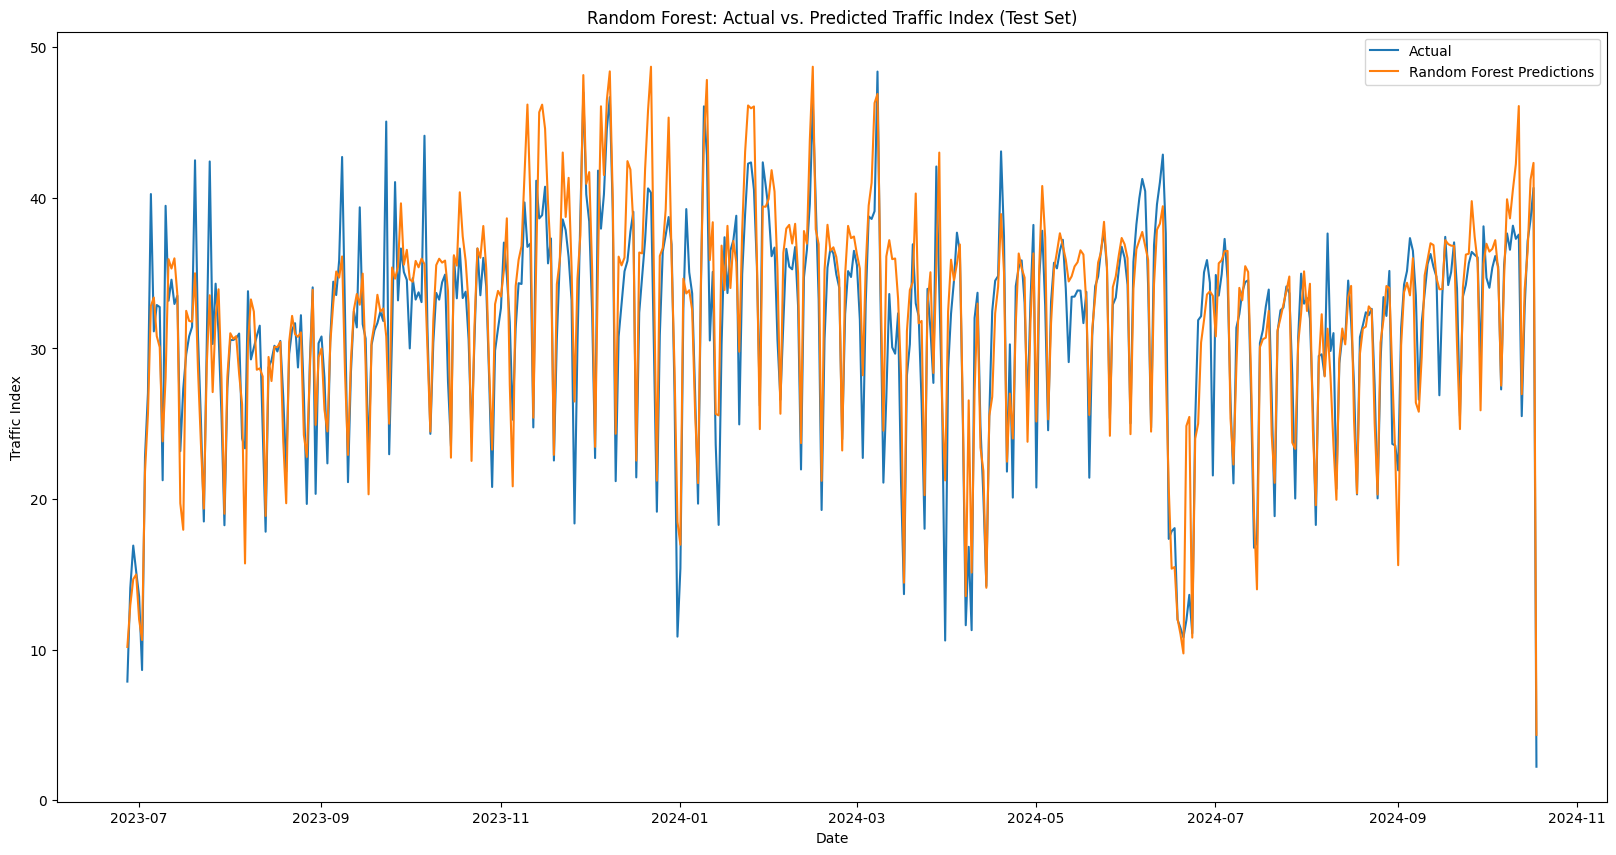

In [31]:
# The comparison plot of actual vs. predicted values
plt.figure(figsize=(20, 10))
sns.lineplot(data=plot_df, x=plot_df.index, y=y_test, label='Actual')
sns.lineplot(data=plot_df, x=plot_df.index, y='rf_predictions', label='Random Forest Predictions')
plt.title('Random Forest: Actual vs. Predicted Traffic Index (Test Set)')
plt.xlabel('Date')
plt.ylabel('Traffic Index')
plt.legend()
plt.show()